# Using APOC for object segmentation in google colab
In this notebook, we demonstrate how to use the accelerated-pixel-and-object-classifier ([APOC](https://github.com/haesleinhuepf/apoc#accelerated-pixel-and-object-classification-apoc)) to segment objects from an example image.



## Getting a GPU

Before executing this notebook in google colab, please swith the runtime to `GPU`. After that, at the top-right, click on 'Connect'.

<img src="https://github.com/BiAPoL/blog/raw/master/docs/robert_haase/clesperanto_google_colab/clesperanto_colab/colab2.png" width="500">

Additionally now, also at the top-right, you should see two very small graphs named  'RAM' and 'Disk'. Click on them to better visualize what computational resources are available for you.

## Installing additional packages

Google colab environment already comes with some popular scientific packages. In case you need to install extra packages to the environment, you can do so with `pip` as shown below.

**So, if running this from google colab**, execute the following line. It installs [pyclesperanto-prototype](https://github.com/clEsperanto/pyclesperanto_prototype#py-clesperanto) and [apoc](https://github.com/haesleinhuepf/apoc#accelerated-pixel-and-object-classification-apoc) into your colab kernel.

In [ ]:
!pip install pyclesperanto_prototype apoc


## Importing packages

The next cell imports the necessary packages we use in this notebook and selects a specific backend for pyclesperanto. 


In [2]:
import apoc
import pyclesperanto_prototype as cle
from skimage.io import imread

*Notice: due to a recent [opencl support on Google colab issue](https://github.com/clEsperanto/pyclesperanto_prototype/issues/300), it is necessary to change the backend to 'cupy' as done by running the cell below.*

In [3]:
cle.select_device("cupy")

'cupy backend (experimental)'

## Loading image
We will be using the `blobs` example image from ImageJ.
We can load it and push it to the GPU as shown below.

/usr/local/lib/python3.10/dist-packages/pyclesperanto_prototype/_tier0/_cuda_backend.py:39: UserWarning: clesperanto's cupy / CUDA backend is experimental. Please use it with care. The following functions are known to cause issues in the CUDA backend:
affine_transform, apply_vector_field, create(uint64), create(int32), create(int64), resample, scale, spots_to_pointlist
  warnings.warn("clesperanto's cupy / CUDA backend is experimental. Please use it with care. The following functions are known to cause issues in the CUDA backend:\n" +


experimental clesperanto CUDAArray([[ 40.  32.  24. ... 216. 200. 200.]
 [ 56.  40.  24. ... 232. 216. 216.]
 [ 64.  48.  24. ... 240. 232. 232.]
 ...
 [ 72.  80.  80. ...  48.  48.  48.]
 [ 80.  80.  80. ...  48.  48.  48.]
 [ 96.  88.  80. ...  48.  48.  48.]], dtype=float32)
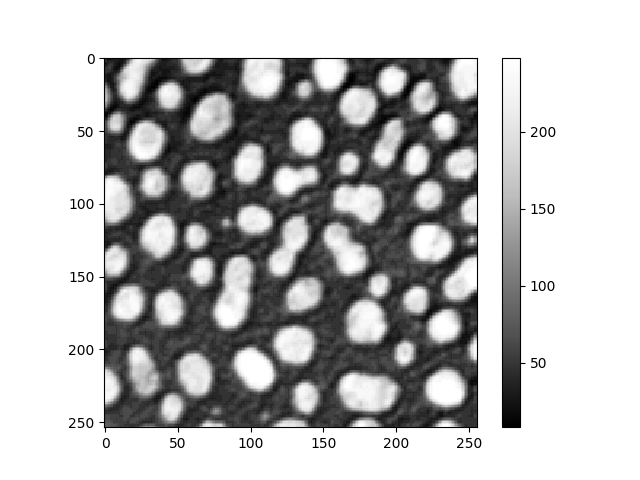
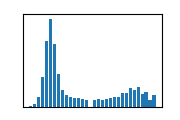

In [4]:
image = cle.push(imread('https://github.com/clEsperanto/napari_pyclesperanto_assistant/raw/4e791cd089b328232f78f220cfd570a0b1e42b1b/napari_pyclesperanto_assistant/data/blobs.tif'))
image

## Loading stored annotations
We load a previously annotated labeled image for the objects we segmented in order to classify them. Again, we display these annotations half transparent on top of the original image.

experimental clesperanto CUDAArray([[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], dtype=float32)
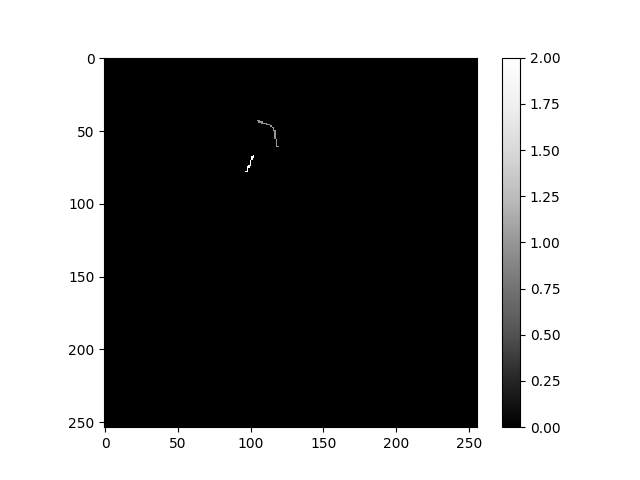
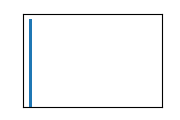

In [5]:
annotations = cle.push(imread('https://github.com/zoccoler/GPU_Accelerated_Image_Processing_on_Cloud_NEUBIAS_Defragmentation_TS2_2023/raw/main/data/pixels_annotations.tif'))
annotations

We can visualize both the original image and the segmentation together with `cle.imshow` by adding some extra arguments to it. We set `continue_drawing` to `True` for the original image and we set `alpha` to `0.5` for the label image.

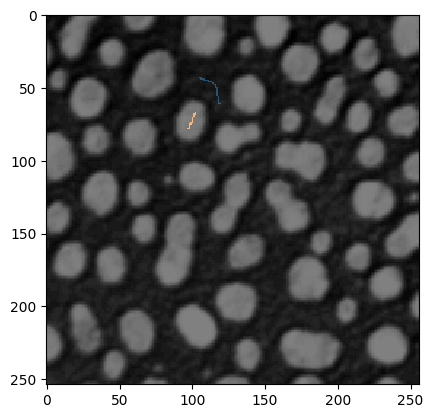

In [6]:
cle.imshow(image, continue_drawing=True)
cle.imshow(annotations, labels=True, alpha=0.5)

In this example, we annotated two classes: 

1. background (blue);

2. foreground/"nuclei" (orange);

## Training an object segmenter

### Connecting google drive

For storing the model we are about to train, we need to connect to google drive. For that, run the cell below.

The procedure involves creating an authorization code. 
In order to generate it, click on the provided link and follow the instructions.
See more detailed instructions [here](https://biapol.github.io/blog/robert_haase/clesperanto_google_colab/readme.html#step-5-connecting-google-drive).

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Creating a classifier

We create a new classifier which will be stored in the specified path in google drive.

In [8]:
# Create an object segmenter
cl_filename_object_segmenter = "gdrive/MyDrive/object_segmenter.cl"
apoc.erase_classifier(cl_filename_object_segmenter)
classifier = apoc.ObjectSegmenter(cl_filename_object_segmenter)

### Training the classifier

We define a few features of interest and train the classifier. We provide as argument the specified features, the loaded annotations and the original image ([see a full example here](https://github.com/haesleinhuepf/apoc/blob/main/demo/demo_object_segmenter.ipynb)).

In [9]:
# define features
features = apoc.PredefinedFeatureSet.small_quick.value

# train it
classifier.train(features, annotations, image)

To get a list of available pre-defined features, run the cell below:

In [ ]:
for feature in apoc.PredefinedFeatureSet:
  print(feature.name + ':\n' + feature.value + '\n')

The pre-trained classifier is saved in google drive.

### Running predictions

Now, we predict the results from the object segmenter and display them.

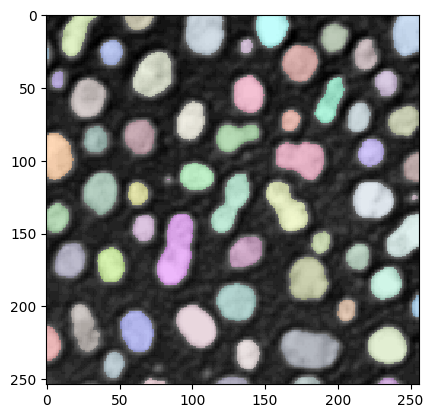

In [11]:
# determine object segmentation
segmentation_result = classifier.predict(image)

# Display results over original image
cle.imshow(image, continue_drawing=True)
cle.imshow(segmentation_result, labels=True, alpha=0.3)